In [6]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [7]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [8]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1898
Number of these with 4 images =  278
Number of these with i3 < 22 =  123


# Three different ways of implementation

All the versions --- 1, 2, and 3 --- agreed on the zeroth and the first moment.

For version 1(code that I wrote + stackExchange), it just implements the algorithm using the definition of the zeroth, first, and the second moment. It does give reasonable values, but it only divides the value of calculated 2nd moments($I_{xx}$, $I_{yy}$, $I_{xy}$) with the zeroth moment once. 

For version 2($skimage.measure.moments$), it gives out ($I_{xx}$, $I_{yy}$, $I_{xy}$). I divided by zeroth moment sqaure. The shape and intensity values are a little odd. 

For version 3(code that I wrote + $scipy.stats.moment$), $scipy.stats.moment$ does array.ravel() (squeeze 2d array into 1d) and calculate the standard deviation for the whole array. This is not what we want.

OM10: Extracted OM10 lens number 25367:
LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------ -------- ---- ----- ... ------------- ------------- -------------
 25367        0    4 0.076 ...         22.41 22.1973271024 22.7045753211
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  3.03192479809e-07
19.6042382643
0.00356053222407
0.0296231889493
19.0272983441
#####################BEFORE DEBLEND PLOT LENSES##################################


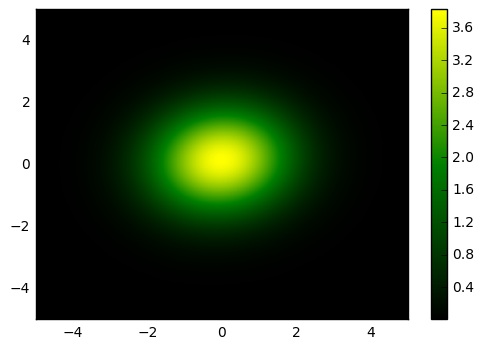

NameError: global name 'intertial_axis' is not defined

In [10]:
realizer.deblend(lensID=k, version=1, null_deblend=True, debug=True, show_plot=True)

In [ ]:
realizer.deblend(lensID=k, version=2, null_deblend=True, debug=True, show_plot=True, report_distance=False)

In [ ]:
realizer.deblend(lensID=k, version=3, null_deblend=True, debug=True, show_plot=True, report_distance=False)